# CO oxidation volcano

## Load input file

In [1]:
from pycatkin.functions.load_input import read_from_input_file

sim_system = read_from_input_file()


Loading input file: input.json.
Reading states:
* s
* sCO
* sO
* CO
* O2
* CO2
Reading scaling relation states:
* SRTS_ox
* SRTS_O2
* sO2
Reading system:
* Pressure: 100000 Pa
* Temperature: 600 K
Reading reactions:
* O2_ads
* CO_ox
* O2_2O
* CO_ads
* 2O_ads
Reading reactor:
* InfiniteDilutionReactor
Done.


## Define a range of binding energies

In [2]:
import numpy as np

be = np.linspace(start=-2.5, stop=0.5, num=10, endpoint=True)


## Define the standard entropies (taken from Atkins, in eV/K)

In [3]:
SCOg = 2.0487e-3
SO2g = 2.1261e-3


## Compute and save the activity

In [4]:

activity = np.zeros((len(be), len(be)))

for iCO, bCO in enumerate(be):
    for iO, bO in enumerate(be):
        
        print('* Binding energy of CO is %1.2f, binding energy of O is %1.2f' % (bCO, bO))

        # (a) Set CO adsorption energy and entropy
        sim_system.reactions['CO_ads'].dErxn_user = bCO
        sim_system.reactions['CO_ads'].dGrxn_user = bCO + SCOg * sim_system.params['temperature']

        # (b) Set O adsorption energy and entropy
        sim_system.reactions['2O_ads'].dErxn_user = 2.0 * bO
        sim_system.reactions['2O_ads'].dGrxn_user = 2.0 * bO + SO2g * sim_system.params['temperature']

        # (c) Add adsorption entropy change for gases
        sim_system.states['sO2'].set_energy_modifier(modifier=SO2g * sim_system.params['temperature'])
        sim_system.states['SRTS_O2'].set_energy_modifier(modifier=SO2g * sim_system.params['temperature'])
        sim_system.states['SRTS_ox'].set_energy_modifier(modifier=(0.5 * SO2g * sim_system.params['temperature'] +
                                                                   SCOg * sim_system.params['temperature']))

        # (d) Set O2 adsorption free energy
        sim_system.reactions['O2_ads'].dGrxn_user = sim_system.states['sO2'].get_free_energy(
            T=sim_system.params['temperature'],
            p=sim_system.params['pressure'])

        # (e) Set CO oxidation free energy barrier
        sim_system.reactions['CO_ox'].dGa_fwd_user = sim_system.states['SRTS_ox'].get_free_energy(
            T=sim_system.params['temperature'],
            p=sim_system.params['pressure']) - (sim_system.reactions['CO_ads'].dGrxn_user +
                                                0.5 * sim_system.reactions['2O_ads'].dGrxn_user)

        # (f) Set O2 dissociation free energy barrier
        sim_system.reactions['O2_2O'].dGa_fwd_user = sim_system.states['SRTS_O2'].get_free_energy(
            T=sim_system.params['temperature'],
            p=sim_system.params['pressure']) - sim_system.reactions['O2_ads'].dGrxn_user

        
        activity[iCO, iO] = sim_system.activity(tof_terms=['CO_ox'])


* Binding energy of CO is -2.50, binding energy of O is -2.50
* Binding energy of CO is -2.50, binding energy of O is -1.75
* Binding energy of CO is -2.50, binding energy of O is -1.00
* Binding energy of CO is -2.50, binding energy of O is -0.25
* Binding energy of CO is -2.50, binding energy of O is 0.50
* Binding energy of CO is -1.75, binding energy of O is -2.50
* Binding energy of CO is -1.75, binding energy of O is -1.75
* Binding energy of CO is -1.75, binding energy of O is -1.00
* Binding energy of CO is -1.75, binding energy of O is -0.25
* Binding energy of CO is -1.75, binding energy of O is 0.50
* Binding energy of CO is -1.00, binding energy of O is -2.50
* Binding energy of CO is -1.00, binding energy of O is -1.75
* Binding energy of CO is -1.00, binding energy of O is -1.00
* Binding energy of CO is -1.00, binding energy of O is -0.25
* Binding energy of CO is -1.00, binding energy of O is 0.50
* Binding energy of CO is -0.25, binding energy of O is -2.50
* Binding e

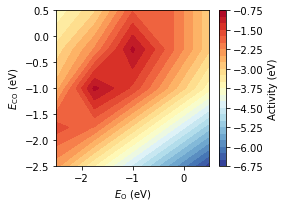

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(4, 3))
CS = ax.contourf(be, be, activity, levels=25, cmap=plt.get_cmap("RdYlBu_r"))
fig.colorbar(CS).ax.set_ylabel('Activity (eV)')
ax.set(xlabel=r'$E_{\mathsf{O}}$ (eV)', ylabel=r'$E_{\mathsf{CO}}$ (eV)')
fig.tight_layout()
fig.savefig('activity.png', format='png', dpi=600)
